# Exploratory Data Analysis (EDA) - MALLORN Astronomical Classification

Notebook này dùng để khám phá dữ liệu, hiểu cấu trúc và đặc điểm của các đối tượng thiên văn (TDE vs Non-TDE).

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cấu hình hiển thị
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Metadata (Train Log)
Đọc file `train_log.csv` chứa thông tin nhãn và các thông số vật lý cơ bản.

In [2]:
# Đường dẫn dữ liệu
DATA_DIR = 'data'
TRAIN_LOG_PATH = os.path.join(DATA_DIR, 'train_log.csv')

# Đọc file log
train_log = pd.read_csv(TRAIN_LOG_PATH)
print(f"Kích thước tập train: {train_log.shape}")
train_log.head()

Kích thước tập train: (3043, 8)


,object_id,Z,Z_err,EBV,SpecType,English Translation,split,target
0,Dornhoth_fervain_onodrim,3.0490,NaN,0.110,AGN,Trawn Folk (Dwarfs) + northern + Ents (people),split_01,0
1,Dornhoth_galadh_ylf,0.4324,NaN,0.058,SN II,Trawn Folk (Dwarfs) + tree + drinking vessel,split_01,0
2,Elrim_melethril_thul,0.4673,NaN,0.577,AGN,Elves + lover (fem.) + breath,split_01,0
3,Ithil_tobas_rodwen,0.6946,NaN,0.012,AGN,moon + roof + noble maiden,split_01,0
4,Mirion_adar_Druadan,0.4161,NaN,0.058,AGN,"jewel, Silmaril + father + Wild Man",split_01,0


## 3. Phân tích phân phối nhãn (Target)
Kiểm tra xem dữ liệu có bị mất cân bằng không (Imbalanced Data).
*   `0`: Non-TDE
*   `1`: TDE

target
0    2895
1     148
Name: count, dtype: int64


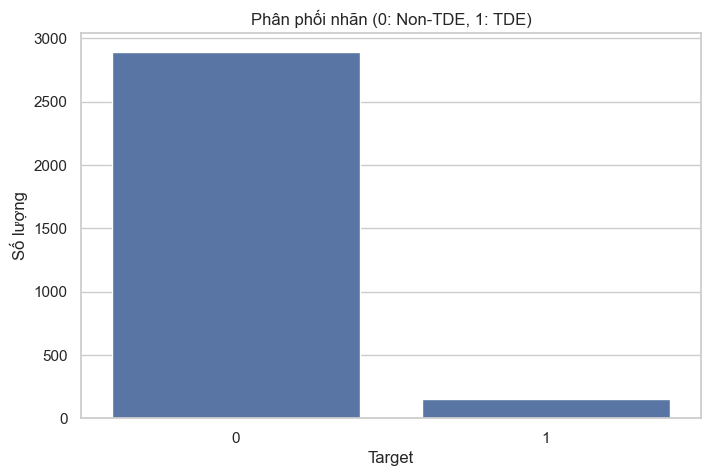

In [3]:
# Kiểm tra tỉ lệ TDE (1) vs Non-TDE (0)
target_counts = train_log['target'].value_counts()
print(target_counts)

plt.figure(figsize=(8, 5))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Phân phối nhãn (0: Non-TDE, 1: TDE)')
plt.xlabel('Target')
plt.ylabel('Số lượng')
plt.show()

## 3.1. Phân tích các đặc trưng trong Log (Z, EBV)
Xem xét phân phối của Redshift (Z) và Extinction (EBV), đồng thời xem mối quan hệ của chúng với nhãn (Target).

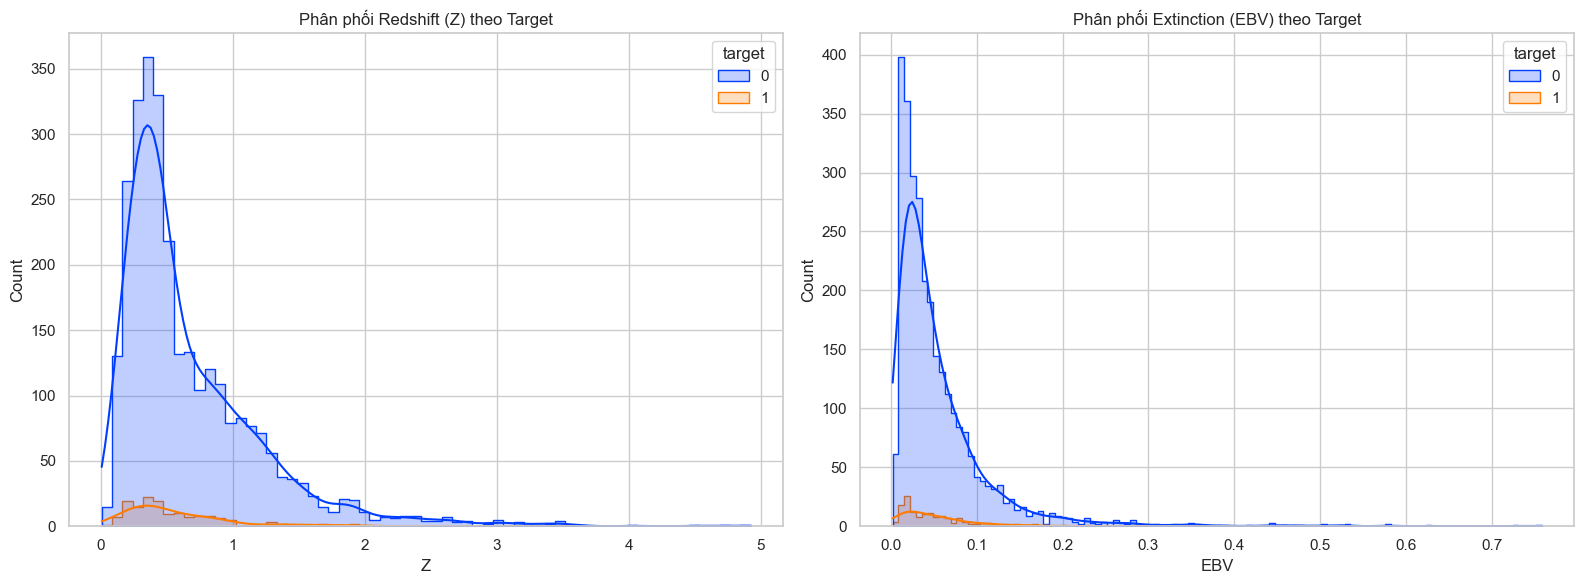

Thống kê Z theo Target:
         count      mean       std       min       25%     50%       75%  \
target                                                                     
0       2895.0  0.676512  0.545418  0.008771  0.318600  0.4865  0.889500   
1        148.0  0.556482  0.384272  0.086580  0.301625  0.4366  0.745625   

          max  
target         
0       4.924  
1       1.951  

Thống kê EBV theo Target:
         count      mean       std    min    25%    50%    75%    max
target                                                               
0       2895.0  0.055783  0.062179  0.002  0.021  0.037  0.069  0.758
1        148.0  0.050932  0.041797  0.006  0.020  0.039  0.065  0.231


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Phân phối Redshift (Z)
sns.histplot(data=train_log, x='Z', hue='target', kde=True, element="step", ax=axes[0], palette='bright')
axes[0].set_title('Phân phối Redshift (Z) theo Target')

# Phân phối EBV
sns.histplot(data=train_log, x='EBV', hue='target', kde=True, element="step", ax=axes[1], palette='bright')
axes[1].set_title('Phân phối Extinction (EBV) theo Target')

plt.tight_layout()
plt.show()

# Thống kê mô tả cho Z và EBV theo nhóm
print("Thống kê Z theo Target:")
print(train_log.groupby('target')['Z'].describe())
print("\nThống kê EBV theo Target:")
print(train_log.groupby('target')['EBV'].describe())

## 4. Hàm hỗ trợ đọc dữ liệu Lightcurve
Dữ liệu lightcurve nằm rải rác trong các thư mục `split_XX`. Cần hàm để đọc đúng file dựa trên `object_id` và `split`.

In [11]:
def get_lightcurve_path(split_name, mode='train'):
    """Lấy đường dẫn file lightcurve dựa trên split"""
    return os.path.join(DATA_DIR, split_name, f'{mode}_full_lightcurves.csv')

def load_lightcurve(object_id, split_name, mode='train'):
    """Đọc dữ liệu lightcurve của một split cụ thể"""
    path = get_lightcurve_path(split_name, mode)
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return None
    
    # Lưu ý: File CSV trong mỗi split khá lớn, chứa nhiều object.
    # Việc đọc toàn bộ file chỉ để lấy 1 object là không tối ưu cho production,
    # nhưng chấp nhận được cho bước EDA này.
    df = pd.read_csv(path)
    result_df = df[df['object_id'] == object_id]
    print(f"Loaded {len(result_df)} rows for object_id {object_id} from {path}")
    return result_df

# Test thử với dòng đầu tiên trong train_log
sample_obj = train_log.iloc[0]
print(f"Đang load object: {sample_obj['object_id']} từ {sample_obj['split']}")
lc_data = load_lightcurve(sample_obj['object_id'], sample_obj['split'])
lc_data.head()

Đang load object: Dornhoth_fervain_onodrim từ split_01
Loaded 65 rows for object_id Dornhoth_fervain_onodrim from data\split_01\train_full_lightcurves.csv


,object_id,Time (MJD),Flux,Flux_err,Filter
0,Dornhoth_fervain_onodrim,63314.4662,-1.630159,0.365777,z
1,Dornhoth_fervain_onodrim,63780.9674,10.499389,0.253867,r
2,Dornhoth_fervain_onodrim,63789.7693,5.866250,1.559241,y
3,Dornhoth_fervain_onodrim,63794.1702,3.903623,0.376854,r
4,Dornhoth_fervain_onodrim,63794.1702,5.226644,0.516864,i


## 5. Trực quan hóa Lightcurve
Vẽ biểu đồ biến thiên độ sáng (Flux) theo thời gian (Time) cho từng kính lọc (Filter).

Loaded 65 rows for object_id Dornhoth_fervain_onodrim from data\split_01\train_full_lightcurves.csv


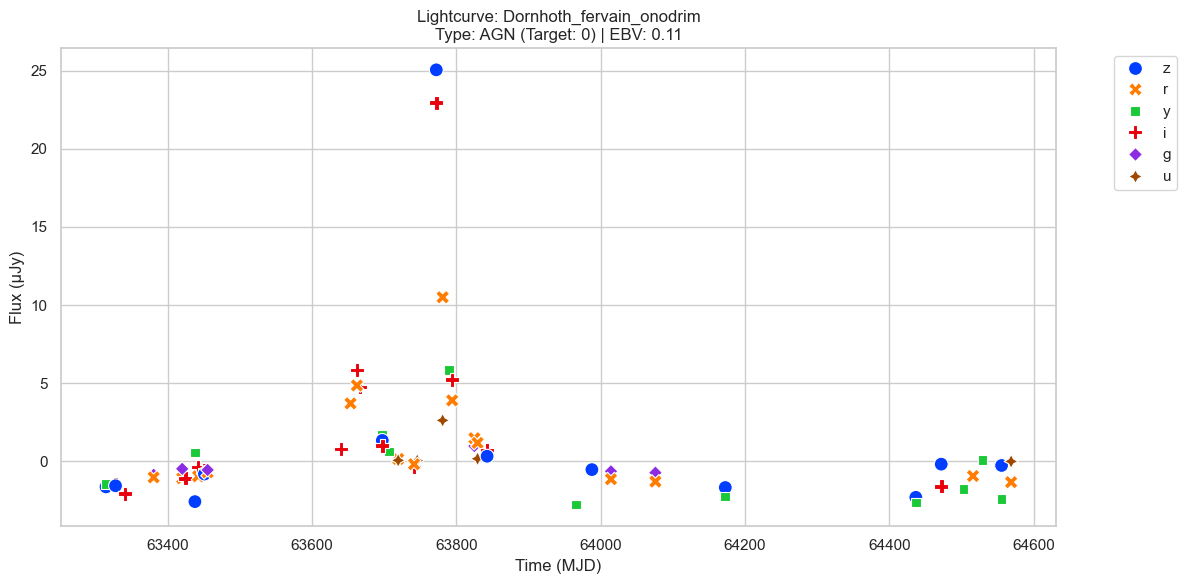

In [12]:
def plot_lightcurve(object_id, split_name, target, ebv, spec_type='Unknown'):
    df = load_lightcurve(object_id, split_name)
    if df is None or df.empty:
        print(f"Không tìm thấy dữ liệu cho {object_id}")
        return
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Time (MJD)', y='Flux', hue='Filter', style='Filter', s=100, palette='bright')
    
    plt.title(f'Lightcurve: {object_id}\nType: {spec_type} (Target: {target}) | EBV: {ebv}')
    plt.xlabel('Time (MJD)')
    plt.ylabel('Flux (μJy)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Vẽ thử mẫu đầu tiên
plot_lightcurve(sample_obj['object_id'], sample_obj['split'], sample_obj['target'], sample_obj['EBV'], sample_obj['SpecType'])

## 6. So sánh TDE vs Non-TDE
Lấy ngẫu nhiên một vài mẫu TDE và Non-TDE để so sánh bằng mắt thường.

=== MẪU TDE ===
Loaded 76 rows for object_id pent_agor_bronwe from data\split_01\train_full_lightcurves.csv


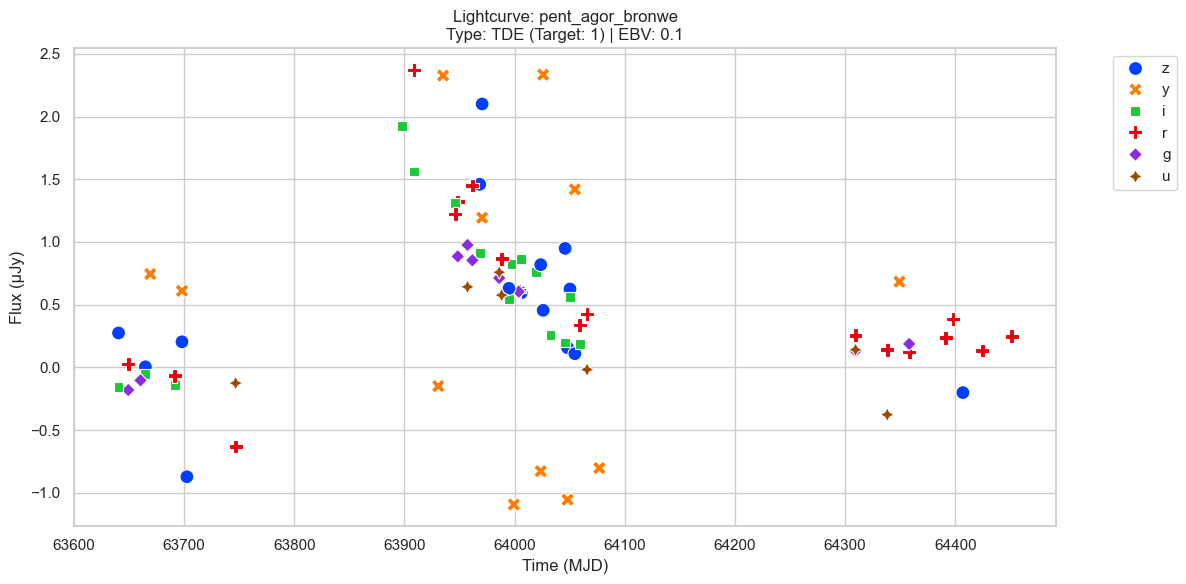

=== MẪU NON-TDE ===
Loaded 153 rows for object_id cyron_gwaun_lain from data\split_19\train_full_lightcurves.csv


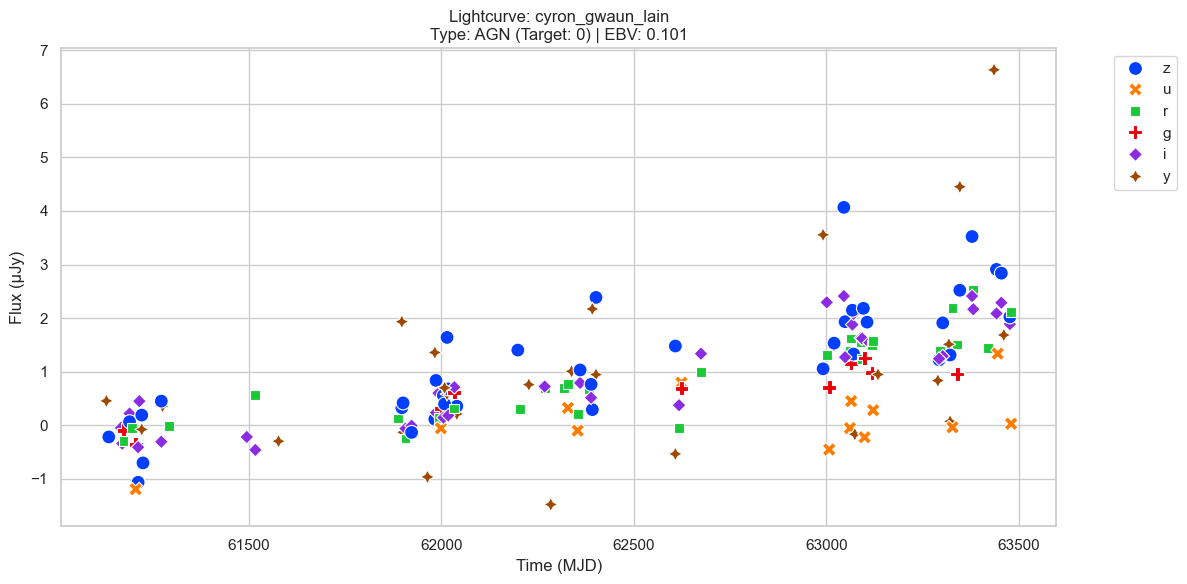

In [13]:
# Lấy ngẫu nhiên 1 TDE (Target = 1)
tde_samples = train_log[train_log['target'] == 1].sample(1)
if not tde_samples.empty:
    tde_sample = tde_samples.iloc[0]
    print("=== MẪU TDE ===")
    plot_lightcurve(tde_sample['object_id'], tde_sample['split'], tde_sample['target'], tde_sample['EBV'], tde_sample['SpecType'])

# Lấy ngẫu nhiên 1 Non-TDE (Target = 0)
non_tde_samples = train_log[train_log['target'] == 0].sample(1)
if not non_tde_samples.empty:
    non_tde_sample = non_tde_samples.iloc[0]
    print("=== MẪU NON-TDE ===")
    plot_lightcurve(non_tde_sample['object_id'], non_tde_sample['split'], non_tde_sample['target'], non_tde_sample['EBV'], non_tde_sample['SpecType'])

## 7. Thống kê đặc trưng từ Lightcurves (Trên tập mẫu)
Vì dữ liệu lightcurve rất lớn, ta sẽ lấy mẫu khoảng 100 đối tượng ngẫu nhiên để phân tích thống kê cơ bản:
*   Số lượng điểm dữ liệu (Number of observations).
*   Độ dài chuỗi thời gian (Time span).
*   Giá trị Flux lớn nhất/nhỏ nhất.

In [14]:
# Lấy mẫu 100 object ngẫu nhiên
sample_objects = train_log.sample(100, random_state=42)
stats_list = []

print("Đang tính toán thống kê trên tập mẫu...")
for _, row in sample_objects.iterrows():
    df = load_lightcurve(row['object_id'], row['split'])
    if df is not None and not df.empty:
        stats = {
            'object_id': row['object_id'],
            'target': row['target'],
            'num_obs': len(df),
            'time_span': df['Time (MJD)'].max() - df['Time (MJD)'].min(),
            'max_flux': df['Flux'].max(),
            'min_flux': df['Flux'].min(),
            'mean_flux': df['Flux'].mean(),
            'std_flux': df['Flux'].std()
        }
        stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
print("Hoàn thành!")
stats_df.head()

Đang tính toán thống kê trên tập mẫu...
Loaded 190 rows for object_id rochir_Sindarin_merilin from data\split_02\train_full_lightcurves.csv
Loaded 165 rows for object_id faradrim_thavron_firen from data\split_19\train_full_lightcurves.csv
Loaded 144 rows for object_id soga_forodrim_aith from data\split_01\train_full_lightcurves.csv
Loaded 129 rows for object_id ithron_galvorn_gaur from data\split_04\train_full_lightcurves.csv
Loaded 140 rows for object_id ai_limlug_ninglor from data\split_07\train_full_lightcurves.csv
Loaded 175 rows for object_id muil_faradrim_ungol from data\split_14\train_full_lightcurves.csv
Loaded 188 rows for object_id nimp_hast_firiel from data\split_12\train_full_lightcurves.csv
Loaded 149 rows for object_id bellas_gul_aras from data\split_17\train_full_lightcurves.csv
Loaded 94 rows for object_id uan_lacha_heron from data\split_15\train_full_lightcurves.csv
Loaded 170 rows for object_id minai_meldir_tinnu from data\split_05\train_full_lightcurves.csv
Loaded 15

,object_id,target,num_obs,time_span,max_flux,min_flux,mean_flux,std_flux
0,rochir_Sindarin_merilin,0,190,2003.1049,12.840083,-3.108868,0.866254,2.473061
1,faradrim_thavron_firen,0,165,1607.5144,3.439166,-2.181382,0.196034,0.937552
2,soga_forodrim_aith,0,144,2174.4961,4.027490,-2.381905,0.250346,0.868254
3,ithron_galvorn_gaur,1,129,2316.0112,3.508676,-3.285605,0.570353,1.169530
4,ai_limlug_ninglor,0,140,2619.6792,3.506385,-2.461538,0.514335,0.877893


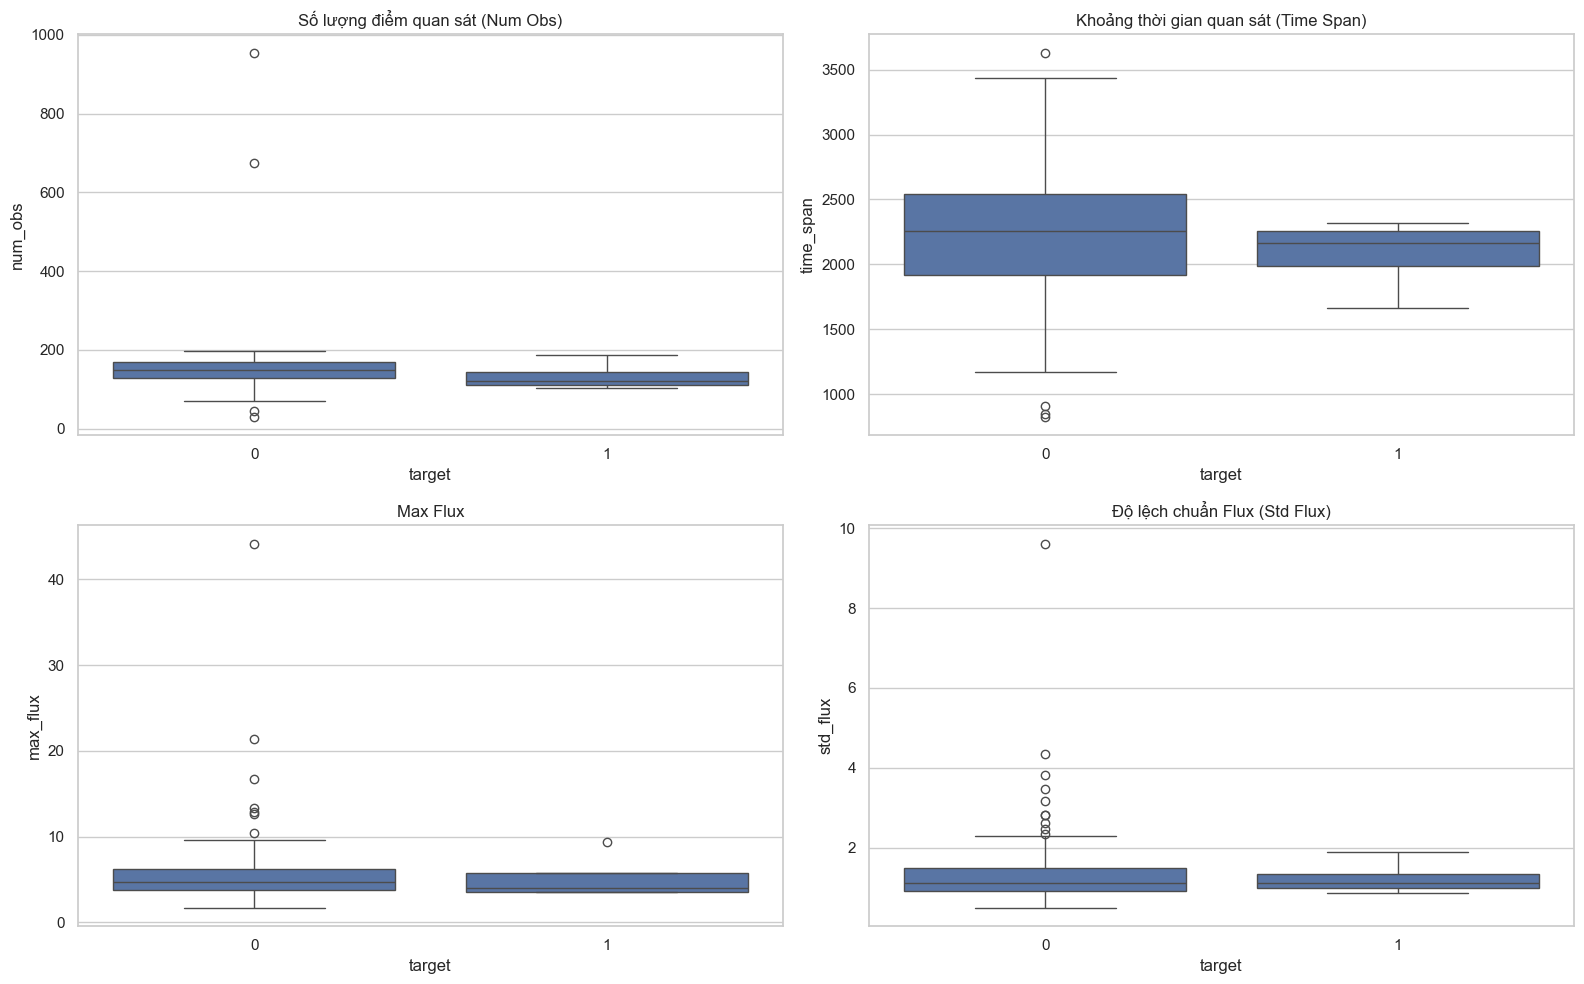

In [15]:
# Vẽ biểu đồ phân phối các thống kê này
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.boxplot(data=stats_df, x='target', y='num_obs', ax=axes[0, 0])
axes[0, 0].set_title('Số lượng điểm quan sát (Num Obs)')

sns.boxplot(data=stats_df, x='target', y='time_span', ax=axes[0, 1])
axes[0, 1].set_title('Khoảng thời gian quan sát (Time Span)')

sns.boxplot(data=stats_df, x='target', y='max_flux', ax=axes[1, 0])
axes[1, 0].set_title('Max Flux')

sns.boxplot(data=stats_df, x='target', y='std_flux', ax=axes[1, 1])
axes[1, 1].set_title('Độ lệch chuẩn Flux (Std Flux)')

plt.tight_layout()
plt.show()